In [1]:
import warnings

import pandas as pd
import numpy as np
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, pipeline
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import category_encoders as ce

warnings.filterwarnings('ignore')

In [2]:
def evaluate_model(X_train, X_val, y_train, y_val):
    model = XGBClassifier(random_state=42, enable_categorical=True, early_stopping_rounds=100, )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='weighted')

In [3]:
from typing import Any, Dict, Sequence


def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.
    Parameters
    ----------
    trial : List[Dict[str, Any]]
    A list of trial dictionaries.
    Returns
    -------
    pd.DataFrame
    A DataFrame with columns for the loss, trial id, and
    values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k: (v[0] if isinstance(v, list) else v)
               for k, v in misc['vals'].items()
               }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

In [4]:
X = pd.read_csv('../data/binned/df.csv')
y = pd.read_csv('../data/binned/y.csv')

for col in X.filter(like='_binned').columns:
    X[col] = X[col].astype('category')

X.filter(like='_binned').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 5 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   avg_home_team_rating_x_ewm_shoton_away_binned  3022 non-null   category
 1   average_rating_away_binned                     3040 non-null   category
 2   average_rating_home_binned                     3040 non-null   category
 3   ewm_possession_home_binned                     3024 non-null   category
 4   avg_away_team_rating_binned                    3040 non-null   category
dtypes: category(5)
memory usage: 16.0 KB


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
evaluate_model(X_train, X_val, y_train, y_val)

0.6772014777016293

In [7]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (2432, 46)
X_val shape: (608, 46)
y_train shape: (2432, 1)
y_val shape: (608, 1)


In [8]:
# from yellowbrick import model_selection as ms
# import os
# 
# def save_files(train, target):
#     output_dir = "../data/encode/"
#     
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     
#     train.to_csv(output_dir + "train.csv", index=False)
#     target.to_csv(output_dir + 'target.csv', index=False)
# 
# def evaluate_model_lr(X_train, X_val, y_train, y_val, learning_rate):
#     encoder = ce.OneHotEncoder(cols=X_train.select_dtypes(include=['object', 'category']).columns, use_cat_names=True, drop_invariant=True, return_df=True)
# 
#     X_train_encoded = encoder.fit_transform(X_train)
#     X_val_encoded = encoder.transform(X_val)
# 
#     model = XGBClassifier(random_state=42, enable_categorical=True, learning_rate=0.3, max_depth=6, min_child_weight=learning_rate,  early_stopping_rounds=100)
#     model.fit(X_train_encoded[choosen_feature], y_train, eval_set=[(X_train_encoded[choosen_feature], y_train), (X_val_encoded[choosen_feature], y_val)], verbose=0)
#     y_pred = model.predict(X_val_encoded[choosen_feature])
#     return f1_score(y_val, y_pred, average='weighted')
# 
# # Define the range of learning_rate values
# learning_rates = [0.15, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]
# min_child_weights = [ 40]
# 
# # Lists to store the F1 scores
# train_scores = []
# val_scores = []
# 
# # Iterate over the learning_rates
# for lr in min_child_weights:
#     f1_train = evaluate_model_lr(X_train, X_train, y_train, y_train, lr)
#     f1_val = evaluate_model_lr(X_train, X_val, y_train, y_val, lr)
#     
#     train_scores.append(f1_train)
#     val_scores.append(f1_val)
# 
# # Plotting the results
# plt.figure()
# plt.plot(min_child_weights, train_scores, label='Training score')
# plt.plot(min_child_weights, val_scores, label='Validation score')
# plt.title('Validation Curve with XGBoost')
# plt.xlabel('Max Depth')
# plt.ylabel('F1 Score (Weighted)')
# plt.legend()
# plt.show()

In [9]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union


def evaluate_model_opt(X_train, X_val, y_train, y_val, space):
    model = XGBClassifier(**space, random_state=42, enable_categorical=True, early_stopping_rounds=75)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='weighted'), model


def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, y_train: pd.Series,
                          X_val: pd.DataFrame, y_val: pd.Series,
                          metric: callable = accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value is 50.
    metric : callable
        Metric to maximize. Default is accuracy
        Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """

    int_vals = ['max_depth']
    space = {k: (int(val) if k in int_vals else val) for k, val in space.items()}
    score, model = evaluate_model_opt(X_train, X_val, y_train, y_val, space)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}


(array([  38.,  198.,  860., 2075., 2893., 2485., 1101.,  289.,   56.,
           5.]),
 array([1.14403561, 1.9787762 , 2.81351679, 3.64825738, 4.48299797,
        5.31773857, 6.15247916, 6.98721975, 7.82196034, 8.65670093,
        9.49144152]),
 <BarContainer object of 10 artists>)

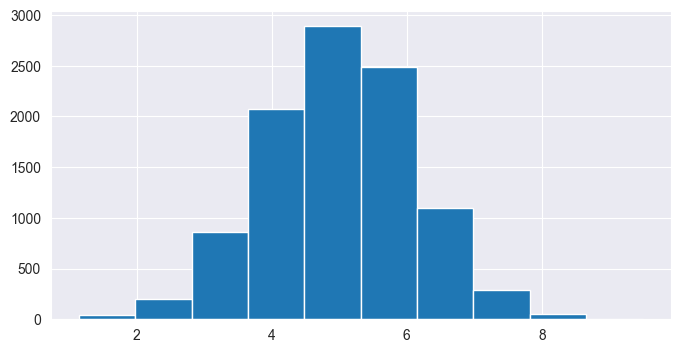

In [91]:
from hyperopt import hp, pyll

# hp.loguniform('min_child_weight', -1, 3)
# uniform_vals = [pyll.stochastic.sample(hp.normal('value', 0.3, 0.06))
uniform_vals = [pyll.stochastic.sample(hp.normal('min_child_weight', 5, 1.1))
                for _ in range(10_000)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)

In [92]:
options_learning_rate = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0)
    # Best Hyperparameters: {'learning_rate': 0.1640487517918771}
}

# options = {
#     'eta': 0.300,  # Default is 0.3, so we search around it
#     'max_depth': 6,  # Default is 6, so we stay close
#     'min_child_weight': hp.uniform('min_child_weight', 1, 10),  # Default is 1, we allow it to go up
#     'gamma': hp.uniform('gamma', 0, 5),  # Default is 0, but we explore a range up to 5
#     'subsample': hp.uniform('subsample', 0.5, 1.0),  # Default is 1, we explore down to 0.5
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Default is 1, we explore down to 0.5
#     'reg_alpha': hp.uniform('reg_alpha', 0, 1),  # Default is 0, exploring up to 1 for L1 regularization
#     'reg_lambda': hp.uniform('reg_lambda', 1, 3),  # Default is 1, exploring up to 3 for L2 regularization
# }

options = {'max_depth': hp.quniform('max_depth', 3, 12, 1),  # tree
           'min_child_weight': hp.normal('min_child_weight', 0.5, 0.1),
           'subsample': hp.normal('subsample', 0.9, 0.03),  # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.normal('reg_alpha', 5, 1.2),
           'reg_lambda': hp.normal('reg_lambda', 5, 1.2),
           'gamma': hp.loguniform('gamma', -10, 10),  # regularization
           'learning_rate': hp.normal('learning_rate', 0.3, 0.06),  # boosting
           }

trials = Trials()

best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_val, y_val, f1_score),
            space=options,
            algo=tpe.suggest,
            max_evals=400,
            trials=trials)

print("Best Hyperparameters:", best)

100%|██████████| 400/400 [01:29<00:00,  4.49trial/s, best loss: -0.6770015668694165]
Best Hyperparameters: {'colsample_bytree': 0.7307859336721938, 'gamma': 0.00942525177904537, 'learning_rate': 0.30852792582831723, 'max_depth': 5.0, 'min_child_weight': 0.5271436534939591, 'reg_alpha': 5.732580040275268, 'reg_lambda': 3.9139571835360183, 'subsample': 0.8258851467157742}


In [93]:
hyper2hr = trial2df(trials)

In [94]:
hyper2hr

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,loss,tid
0,0.559068,605.885982,0.322781,8.0,0.434988,5.890261,5.647479,0.896624,-0.381902,0
1,0.914794,0.001361,0.261064,8.0,0.530273,4.754804,3.510496,0.891918,-0.647405,1
2,0.990747,0.004121,0.279292,5.0,0.542027,5.921292,6.255138,0.837551,-0.673689,2
3,0.885304,0.000393,0.311283,4.0,0.341683,6.482661,5.115809,0.916541,-0.648756,3
4,0.788329,4301.341968,0.277788,9.0,0.440351,5.443675,4.911832,0.906606,-0.381902,4
...,...,...,...,...,...,...,...,...,...,...
395,0.984011,0.000575,0.255887,6.0,0.677916,4.400558,5.601780,0.837114,-0.667269,395
396,0.968731,450.510078,0.301706,5.0,0.523436,7.698779,6.062474,0.916552,-0.381902,396
397,0.705553,0.027244,0.282946,8.0,0.501355,3.916339,7.324739,0.821382,-0.642097,397
398,0.618086,0.098025,0.288945,6.0,0.540053,4.823908,6.844746,0.866415,-0.658673,398


<Axes: >

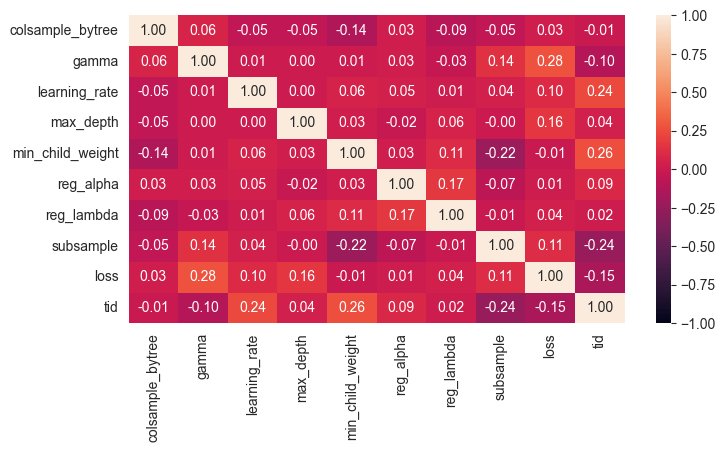

In [95]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(hyper2hr.corr(method='spearman'),
             annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
            )

<Axes: xlabel='tid', ylabel='loss'>

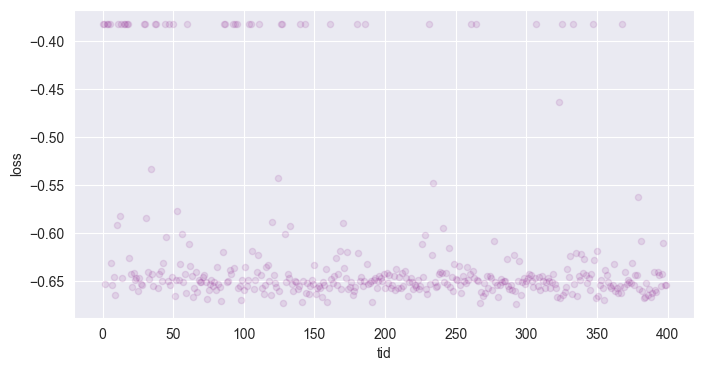

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .plot.scatter(x='tid', y='loss', alpha=.1, color='purple', ax=ax)
 )

<Axes: xlabel='max_depth', ylabel='loss'>

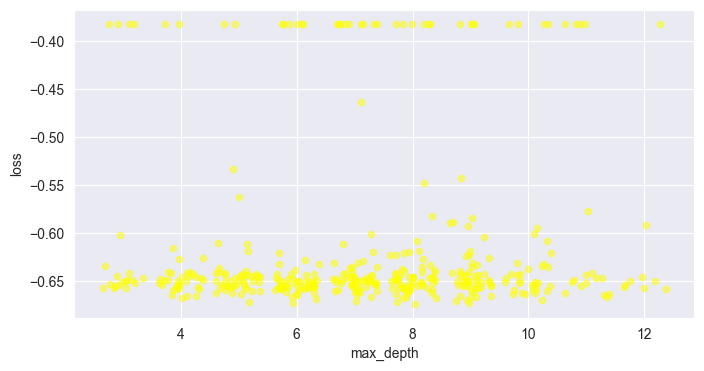

In [17]:
def jitter(df: pd.DataFrame, col: str, amount: float = 1) -> pd.Series:
    """
        Add random noise to the values in a Pandas DataFrame column.
        This function adds random noise to the values in a specified
        column of a Pandas DataFrame. The noise is uniform random
        noise with a range of `amount` centered around zero. The
        function returns a Pandas Series with the jittered values.
        Parameters
        ----------
        df : pd.DataFrame
        The input DataFrame.
        col : str
        The name of the column to jitter.
        amount : float, optional
        The range of the noise to add. The default value is 1.
        Returns
        -------
        pd.Series
        A Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount / 2, high=amount / 2,
                             size=df.shape[0])
    return df[col] + vals
    fig, ax = plt.subplots(figsize=(8, 4))
    (hyper2hr
     .assign(max_depth=lambda df: jitter(df, 'max_depth', amount=.8))
     .plot.scatter(x='max_depth', y='loss', alpha=.1, color='purple', ax=ax)
     )


# This makes it quite clear that the algorithm spent a good amount of time at depth 6.
# If we want to get even fancier, we can color this by trial attempt. The later attempts are
# represented by the yellow color.
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .assign(max_depth=lambda df: jitter(df, 'max_depth', amount=.8))
 .plot.scatter(x='max_depth', y='loss', alpha=.5,
               color='yellow', cmap='viridis', ax=ax)
 )


In [25]:
long_params = {
    'colsample_bytree': 0.6659257109155655,
    'gamma': 0.3135473680762645,
    'learning_rate': 0.21506452935724862,
    'max_depth': 8,
    'min_child_weight': 0.5801390722186286,
    'reg_alpha': 8.23474840926116,
    'reg_lambda': 7.147887178400123,
    'subsample': 0.7291736901442392
}

In [37]:
xg_ex = XGBClassifier(**long_params, early_stopping_rounds=75, random_state=42,
                          n_estimators=500, enable_categorical=True,)
xg_ex.fit(X_train, y_train,
          eval_set=[(X_train, y_train),
                    (X_val, y_val)],
          verbose=0)

y_pred = xg_ex.predict(X_val)

f1_score(y_val, y_pred, average='weighted')

0.6736887624270519

<Axes: xlabel='max_depth', ylabel='loss'>

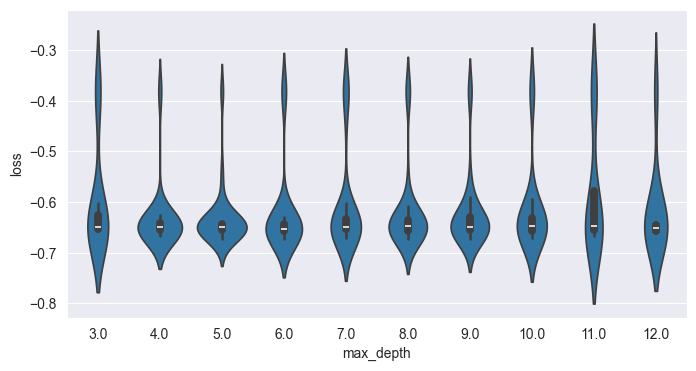

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='max_depth', y='loss', data=hyper2hr, ax=ax)